<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 10th exercise: <font color="#C70039">Interpretable Machine Learning by means of Shapley Values</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Student: Nicolas Rehbach
* Matriculation Number: 11133387
* Date:   15.12.2022

<img src="https://shap.readthedocs.io/en/latest/_images/example_notebooks_overviews_An_introduction_to_explainable_AI_with_Shapley_values_13_0.png" style="float: center;" width="600">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:

Before using Shapley values to explain complicated models, it is helpful to understand how they work for simple models.

In this respect the example in this notebook computes a model for the titanic data set (downloaded from Kaggle) and uses its outputs for explanation of feature importance using SHAP deepexplainer. In addition, several different visualization techniques (plots) for Shapley values are going to be demonstrated. 

For a description of the features please refer to <a href="https://www.kaggle.com/competitions/titanic/data">Kaggle Titanic data set</a>.

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
4. Develop a CNN for image classification and adapt the Shapley Value idea to that model. Comment your entire code.  
---------------------------------

## Imports
Import all necessary python utilities.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
import tensorflow as tf
import os
%matplotlib inline
import shap
import warnings 
warnings.filterwarnings('ignore')
import ssl

## load build-in dataset
take the titanic data set

In [2]:
os.chdir('./data/titanic/')
train_data = pd.read_csv('./train.csv', index_col=0)
test_data = pd.read_csv('./test.csv', index_col=0)
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Preprocessing
Since the titanic data is a raw data set there is a need to preprocess it by dropping unnecessary columns, handling missing data, converting categorical features to numeric features and conducting one-hot encoding.

In [3]:
def data_preprocessing(df):
    
    df = df.drop(columns=['Name', 'Ticket', 'Cabin'])
    
    # fill na
    df[['Age']] = df[['Age']].fillna(value=df[['Age']].mean())
    df[['Embarked']] = df[['Embarked']].fillna(value=df['Embarked'].value_counts().idxmax())
    df[['Fare']] = df[['Fare']].fillna(value=df[['Fare']].mean())
    
    # encode categorical features into numeric
    df['Sex'] = df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    
    # one-hot encoding
    embarked_one_hot = pd.get_dummies(df['Embarked'], prefix='Embarked')
    
    df = df.drop('Embarked', axis=1)
    df = df.join(embarked_one_hot)
    
    return df

# training data processing
train_data = data_preprocessing(train_data)
train_data.isnull().sum()

# create data for training
x_train = train_data.drop(['Survived'], axis=1).values

# Check testing data
test_data.isnull().sum()

# normalize training data
scale = StandardScaler()
x_train = scale.fit_transform(x_train)

# prepare y_train
y_train = train_data['Survived'].values

# preprocess testing data
test_data = data_preprocessing(test_data)
x_test = test_data.values.astype(float)

# normalize testing data
x_test = scale.transform(x_test)

# Check testing data
test_data.isnull().sum()

Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [4]:
x_train

array([[ 0.82737724, -0.73769513, -0.5924806 , ..., -0.48204268,
        -0.30756234,  0.61583843],
       [-1.56610693,  1.35557354,  0.63878901, ...,  2.0745051 ,
        -0.30756234, -1.62380254],
       [ 0.82737724,  1.35557354, -0.2846632 , ..., -0.48204268,
        -0.30756234,  0.61583843],
       ...,
       [ 0.82737724,  1.35557354,  0.        , ..., -0.48204268,
        -0.30756234,  0.61583843],
       [-1.56610693, -0.73769513, -0.2846632 , ...,  2.0745051 ,
        -0.30756234, -1.62380254],
       [ 0.82737724, -0.73769513,  0.17706291, ..., -0.48204268,
         3.25137334, -1.62380254]])

### Build a simple vanilla ANN, compile and fit the model.

In [5]:
model = Sequential()
model.add(Dense(32, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))

# compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# fit model
model.fit(x_train, y_train, epochs=100, batch_size=64)

Metal device set to: Apple M1
Epoch 1/100


2022-12-15 12:26:24.049338: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-15 12:26:24.049426: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-12-15 12:26:24.161283: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 9/14 [==================>...........] - ETA: 0s - loss: 0.7286 - accuracy: 0.4306

2022-12-15 12:26:24.391927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 10ms/step - loss: 0.7145 - accuracy: 0.4826
Epoch 2/100
14/14 [==============================] - 0s 6ms/step - loss: 0.6820 - accuracy: 0.6173
Epoch 3/100
14/14 [==============================] - 0s 6ms/step - loss: 0.6632 - accuracy: 0.7082
Epoch 4/100
14/14 [==============================] - 0s 6ms/step - loss: 0.6369 - accuracy: 0.7273
Epoch 5/100
14/14 [==============================] - 0s 6ms/step - loss: 0.5922 - accuracy: 0.7396
Epoch 6/100
14/14 [==============================] - 0s 6ms/step - loss: 0.5712 - accuracy: 0.7632
Epoch 7/100
14/14 [==============================] - 0s 6ms/step - loss: 0.5172 - accuracy: 0.7868
Epoch 8/100
14/14 [==============================] - 0s 6ms/step - loss: 0.5225 - accuracy: 0.7800
Epoch 9/100
14/14 [==============================] - 0s 6ms/step - loss: 0.5086 - accuracy: 0.7845
Epoch 10/100
14/14 [==============================] - 0s 6ms/step - loss: 0.5016 - accuracy: 0.7834
Epoch 11/100
14/14 [

14/14 [==============================] - 0s 6ms/step - loss: 0.3856 - accuracy: 0.8406
Epoch 84/100
14/14 [==============================] - 0s 6ms/step - loss: 0.3830 - accuracy: 0.8406
Epoch 85/100
14/14 [==============================] - 0s 6ms/step - loss: 0.3923 - accuracy: 0.8339
Epoch 86/100
14/14 [==============================] - 0s 6ms/step - loss: 0.4040 - accuracy: 0.8373
Epoch 87/100
14/14 [==============================] - 0s 6ms/step - loss: 0.3898 - accuracy: 0.8361
Epoch 88/100
14/14 [==============================] - 0s 6ms/step - loss: 0.3780 - accuracy: 0.8339
Epoch 89/100
14/14 [==============================] - 0s 6ms/step - loss: 0.3842 - accuracy: 0.8384
Epoch 90/100
14/14 [==============================] - 0s 6ms/step - loss: 0.3824 - accuracy: 0.8418
Epoch 91/100
14/14 [==============================] - 0s 6ms/step - loss: 0.3888 - accuracy: 0.8429
Epoch 92/100
14/14 [==============================] - 0s 7ms/step - loss: 0.3825 - accuracy: 0.8440
Epoch 93/100


### Now, compute the Shapley values

In [6]:
explainer = shap.DeepExplainer(model, x_train)
shap_values = explainer.shap_values(x_test)

2022-12-15 12:26:34.040370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 12:26:36.578131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


### Shapley values interpretation 
#### Global interpretation method

The summary plot shows the most important features and the magnitude of their impact on the model. It is the global interpretation.

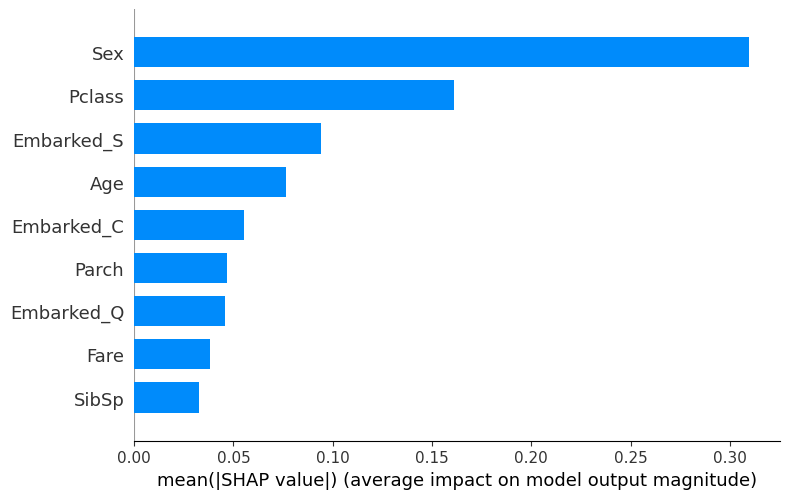

In [7]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = test_data.columns)

#### Local Interpretation methods
##### Force plot
The force plot is great for seeing where the “output value” fits in relation to the “base value”. 
Further, it is possible to observe which features have a positive (red) or negative (blue) impact on the prediction and in addition the magnitude of the impact.

In [8]:
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = test_data.columns)

##### Decision plot
The decision plot enables to observe the amplitude of each change taken by a sample for the values of the displayed features.

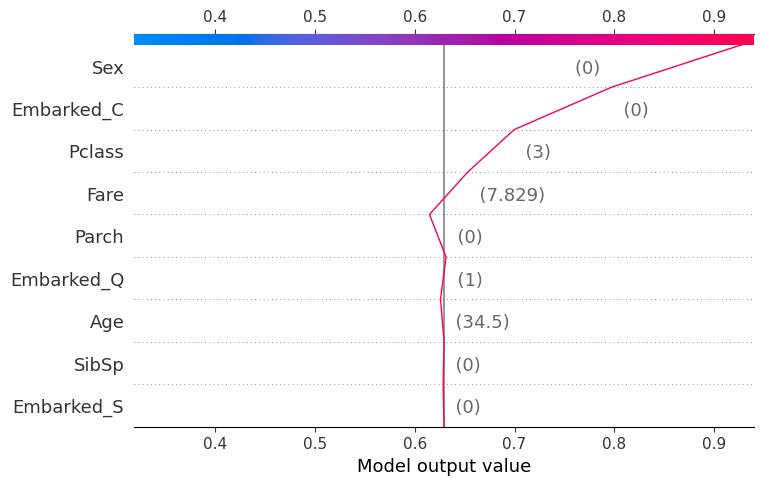

In [9]:
shap.decision_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = test_data.iloc[0,:], 
                   feature_names = test_data.columns.tolist())

##### Waterfall plot
The waterfall plot allows for seeing the amplitude and the nature of the impact of a feature. 
It also allows for seeing the order of importance of the features and the values taken by each feature for the sample.

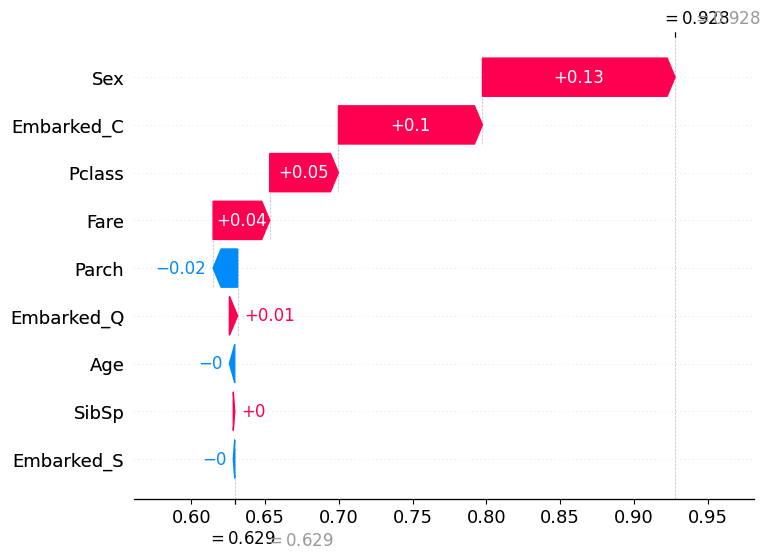

In [10]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][0], 
                                       feature_names = test_data.columns)

## Classify using Shapley Values!

In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator, array_to_img #transfer the image data into a np array?
from tensorflow.keras import optimizers
import tensorflow as tf
import os
%matplotlib inline
import shap
import warnings 
warnings.filterwarnings('ignore')
import ssl
from tqdm import tqdm #a progress bar
import cv2

In [12]:
ssl._create_default_https_context = ssl._create_unverified_context
cifar10 = tf.keras.datasets.cifar10.load_data()

(x_train, y_train), (x_test, y_test) = cifar10

After loading the dataset we reshape and normalize the data as usual. We define the type as float32 and divide through 255 to have numbers between 0 and 1 for the pixel intensity.

In [13]:
x_train.shape

(50000, 32, 32, 3)

In [14]:
x_train = x_train.reshape(50000, 32, 32, 3).astype("float32") / 255
x_test = x_test.reshape(10000, 32, 32, 3).astype("float32") / 255
y_train = y_train.reshape(50000,)
y_test = y_test.reshape(10000,)

Build CNN

In [15]:
# Architecture
# General Observation: Shapley values dont like Leaky Relus.
# Convolutional Layer: Can learn from the local pattern e.g shapes etc.
# Dense Layer: Can only learn from the global patterns of all pixels
# Sequential model: each layer has exactly one input and one output layer
# Max pooling: selecting the maximum value from a 2x2 tensor/block
# MaxPooling helps the CNN to focus on the foreground 
# Adding dropout in the long run resulted in worse results.

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (32, 32, 3), padding = 'same'))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding = 'same'))

model.add(tf.keras.layers.MaxPool2D((2,2) , padding = 'same'))

model.add(tf.keras.layers.Conv2D(64, (5,5), activation='relu', padding = 'same'))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding = 'same'))

model.add(tf.keras.layers.MaxPool2D((2,2)))

model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding = 'same'))
model.add(tf.keras.layers.Conv2D(128, (5,5), activation='relu', padding = 'same'))

model.add(tf.keras.layers.MaxPool2D((2,2)))


model.add(tf.keras.layers.MaxPool2D((2,2)))

model.add(tf.keras.layers.Flatten())

#Using softmax to get a probability (between zero and one)
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        51264     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

In [17]:
# Compile and train the model
# Trying different losses: mse does not work, KL Divergence is not suited for this
# RMSprop seems to be another good optimizer
model.compile(
      loss=tf.keras.losses.sparse_categorical_crossentropy,
      optimizer=tf.keras.optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

In [18]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 25)

Epoch 1/25
   1/1563 [..............................] - ETA: 11:12 - loss: 2.3022 - sparse_categorical_accuracy: 0.1875

2022-12-15 12:26:40.659770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - ETA: 0s - loss: 1.5691 - sparse_categorical_accuracy: 0.4183

2022-12-15 12:27:07.804077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 30s 19ms/step - loss: 1.5691 - sparse_categorical_accuracy: 0.4183 - val_loss: 1.1820 - val_sparse_categorical_accuracy: 0.5752
Epoch 2/25
1563/1563 [==============================] - 30s 19ms/step - loss: 1.0545 - sparse_categorical_accuracy: 0.6239 - val_loss: 0.9835 - val_sparse_categorical_accuracy: 0.6540
Epoch 3/25
1563/1563 [==============================] - 30s 19ms/step - loss: 0.8424 - sparse_categorical_accuracy: 0.7029 - val_loss: 0.8560 - val_sparse_categorical_accuracy: 0.7096
Epoch 4/25
1563/1563 [==============================] - 30s 19ms/step - loss: 0.7037 - sparse_categorical_accuracy: 0.7524 - val_loss: 0.7987 - val_sparse_categorical_accuracy: 0.7272
Epoch 5/25
1563/1563 [==============================] - 30s 19ms/step - loss: 0.6000 - sparse_categorical_accuracy: 0.7905 - val_loss: 0.8227 - val_sparse_categorical_accuracy: 0.7289
Epoch 6/25
1563/1563 [==============================] - 30s 19ms/step - loss: 0.5262 - spar

In [19]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print ('Test loss: {}, Test accuracy: {}'.format(test_loss, test_accuracy*100))

313/313 [==============================] - 3s 10ms/step - loss: 1.3266 - sparse_categorical_accuracy: 0.7497
Test loss: 1.3266046047210693, Test accuracy: 74.97000098228455


In [20]:
model.save("shapley25epochs_76acc.model")

INFO:tensorflow:Assets written to: shapley25epochs_76acc.model/assets


INFO:tensorflow:Assets written to: shapley25epochs_76acc.model/assets


In [21]:
# class label list
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# example image for each class
images_dict = dict()

for i, l in enumerate(y_train):
    if len(images_dict)==50:
        break
    if l not in images_dict.keys():
        images_dict[l] = x_train[i].reshape((32, 32,3))
images_dict = dict(sorted(images_dict.items()))
    
# example image for each class for test set
x_test_dict = dict()
for i, l in enumerate(y_test):
    if len(x_test_dict)==10:
        break
    if l not in x_test_dict.keys():
        x_test_dict[l] = x_test[i]
        
# order by class
x_test_each_class = [x_test_dict[i] for i in sorted(x_test_dict)]
x_test_each_class = np.asarray(x_test_each_class)

# Compute predictions
predictions = model.predict(x_test_each_class)
predicted_class = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 107ms/step


2022-12-15 12:39:37.644197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [22]:
# plot actual and predicted class
def plot_actual_predicted(images, pred_classes):
    fig, axes = plt.subplots(1, 11, figsize=(16, 15))
    axes = axes.flatten()
  
    # plot
    ax = axes[0]
    dummy_array = np.array([[[0, 0, 0, 0]]], dtype='uint8')
    ax.set_title("Base reference")
    ax.set_axis_off()
    ax.imshow(dummy_array, interpolation='nearest')
    
    # plot image
    for k,v in images.items():
        ax = axes[k+1]
        ax.imshow(v, cmap=plt.cm.binary)
        ax.set_title(f"True: %s \nPredict: %s" % (class_names[k], class_names[pred_classes[k]]))
        ax.set_axis_off()
    
    plt.tight_layout()
    plt.show()

In [23]:
# select background for shap
background = x_train[np.random.choice(x_train.shape[0], 1000, replace=False)]

# use DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model, background)

# compute the shapley values
shap_values = explainer.shap_values(x_test_each_class)

2022-12-15 12:39:38.041104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 12:39:49.946005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 12:40:01.830420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 12:40:13.746506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 12:40:25.723053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 12:40:37.893218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-15 12:40:50.027814: I tensorflow/core/grappler/optimizers/cust

Observations:

1st Neural Network did not work out well. Everything is predicted as frog. Only the middle of the pictures is analyzed by the shapley values. Maybe a higher amount of params is necessary (currently only 374,730). Also dense layers were not included.

2nd Neural Network did well. It classified 6/10 images correctly. To further improve the Network, additional layers should be added. Including a dense layer really optimized the classification. Also the epochs or patchsize could be tuned.

3rd Neural Network did not perform at all since it used the KL divergence. Everything is a deer this time.

4th Neural Network used the sparse categorical crossentrophy. This was also used in the sample solution and according to this [blog post](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/), cross entrophy is the default for multi class classification. 8/10 were correctly classified.

5th Neural Network consisted of one 32 input neuron layer, two 64 neuron layers and two 128 neuron layers. Additionally the convolution layers were changed between 3 and 5 for experimenting. Overall a test accuracy of 76.6 was achieved by using 10 epochs.

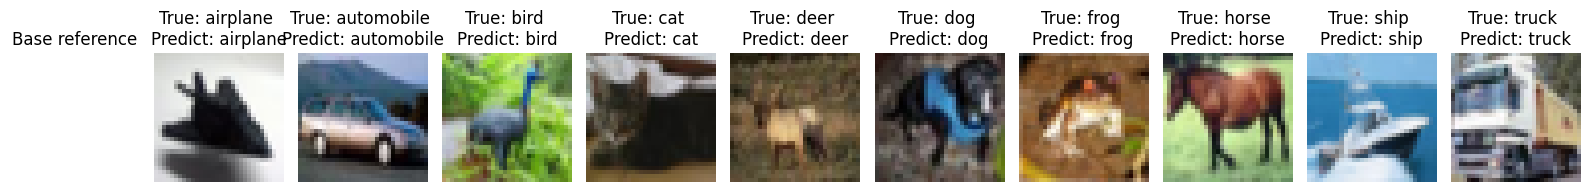

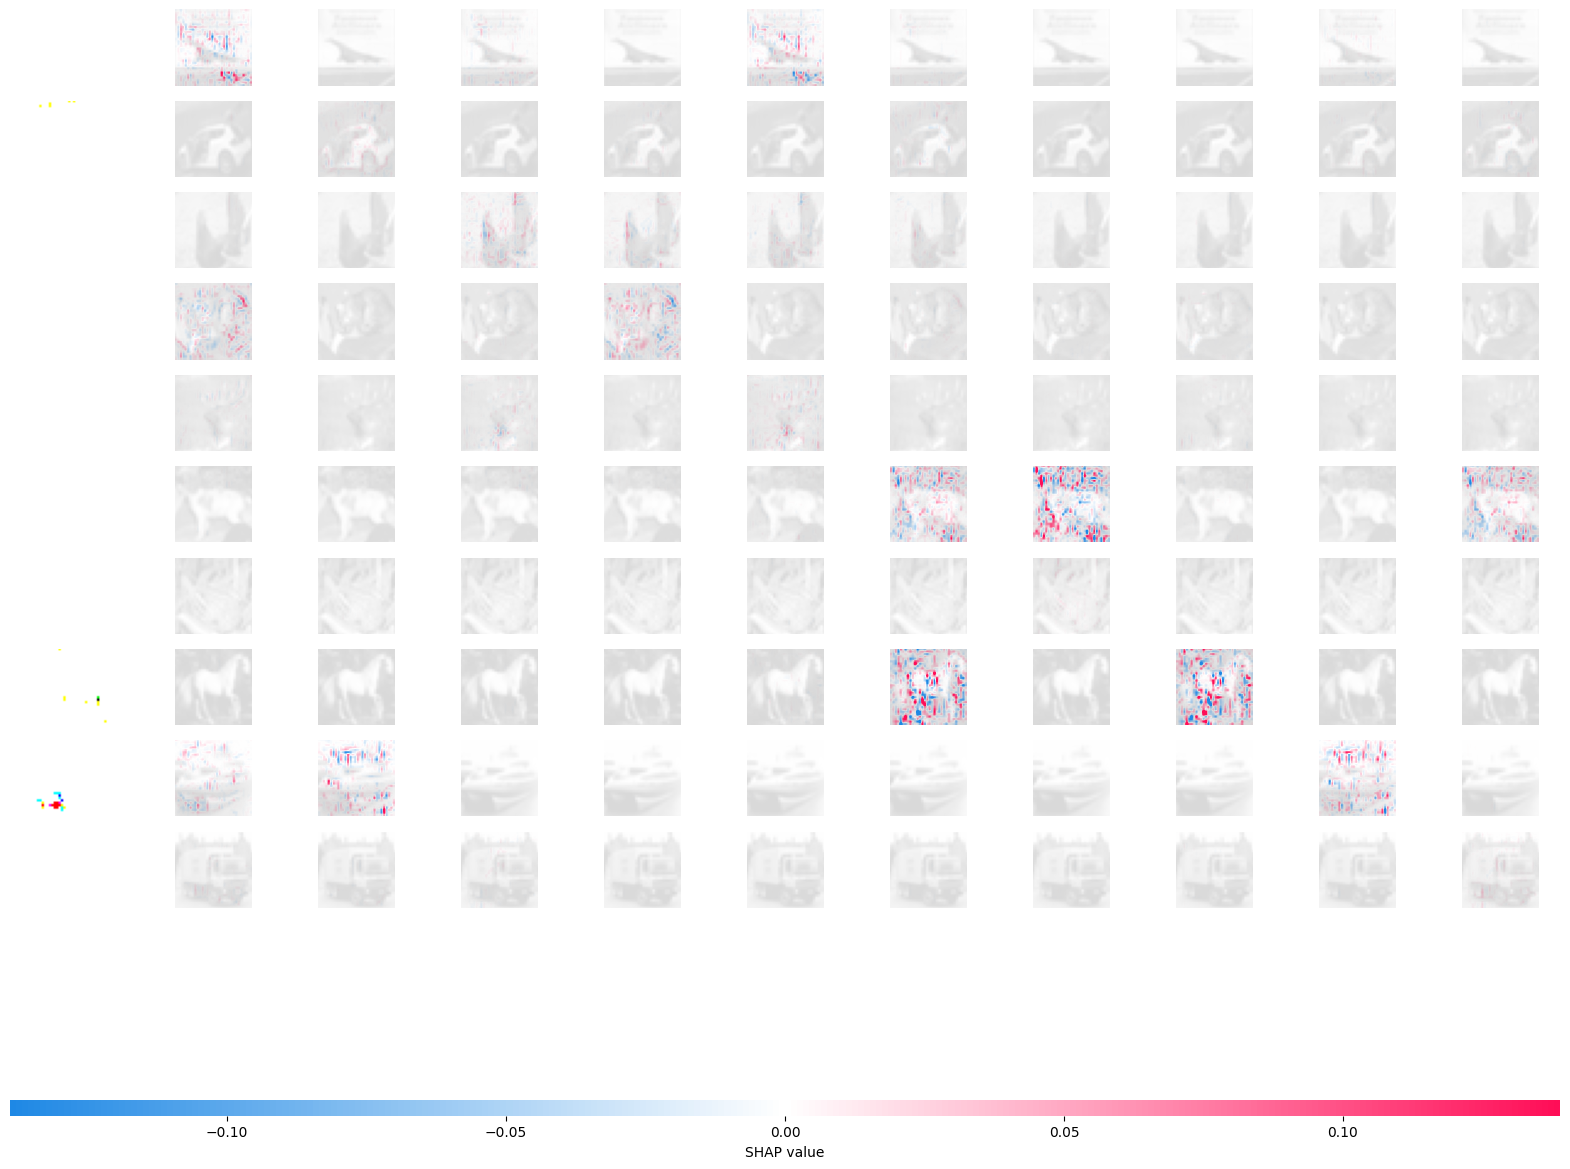

In [24]:
plot_actual_predicted(images_dict, predicted_class)
print()
shap.image_plot(shap_values, x_test_each_class* 256)

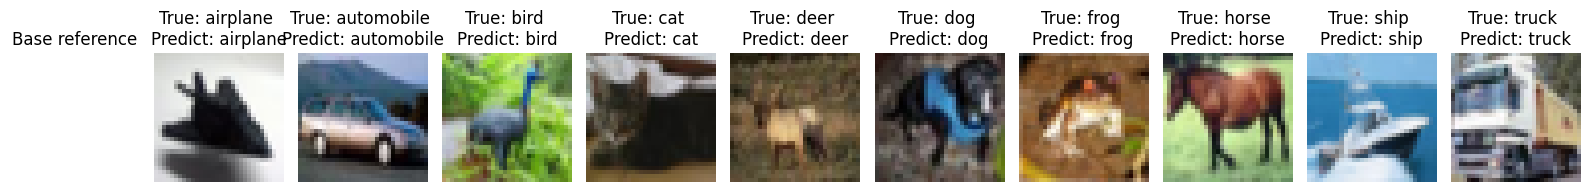

In [25]:
plot_actual_predicted(images_dict, predicted_class)

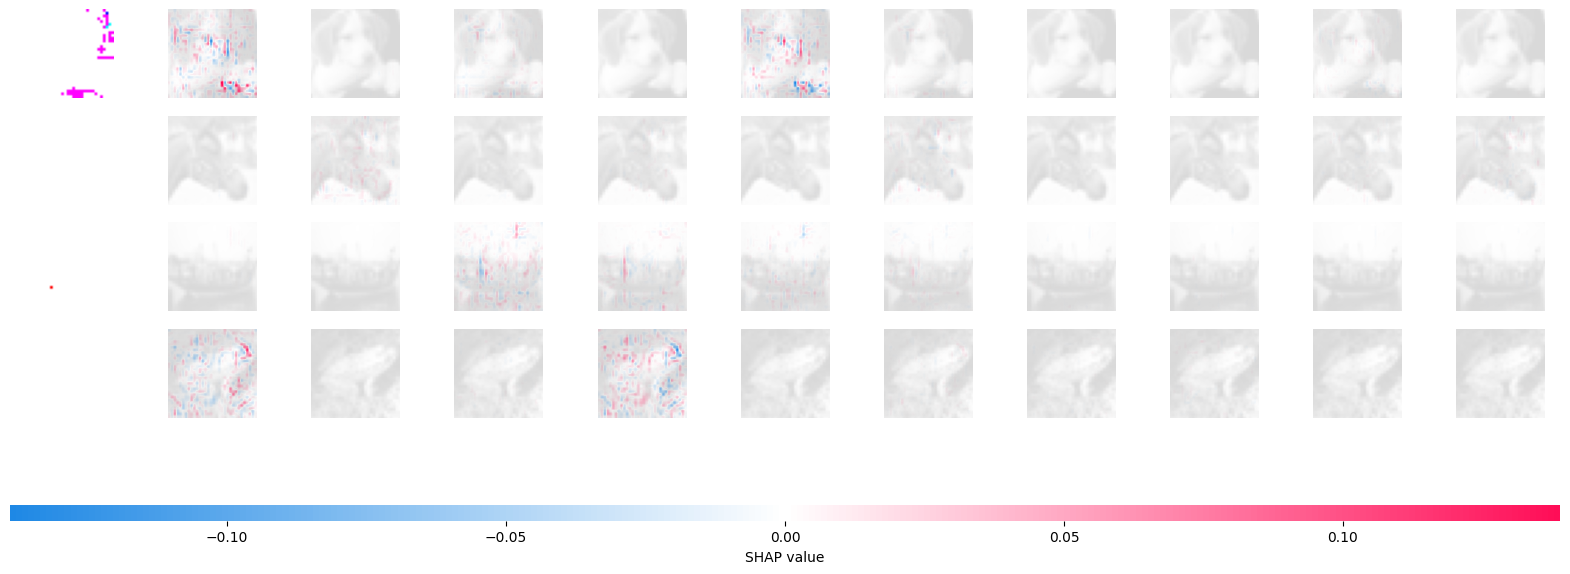

In [26]:
shap.image_plot(shap_values, x_test[16:20]* 256)

## Summary

After trying out different Neural Network architectures one can observe problems to classify the smaller animals correctly. While the plane, ship and horse were sucessfully identified, the dog, deer, bird and cat were oftentimes a problem. 

When observing the shapley values for each picture one can analyze the added possibility to classify the pictures correctly according to the pixels. While it is hard to analyze the values due to the low resolution, we can still observe some interesting patterns. For the car, we can observe high shapley values for the area surrounding the tire and for the horse positive shapley values surrounding the head. Also the frog is nicely outlined by the shapley values for image 20.

It would be interesting to analyze the shapley-values of our stroke dataset.

## Applying shapley-values to the Stroke dataset.


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import plot_tree

In [4]:
#read in the data
stroke_df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
stroke_df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [6]:
# Gender: 0 = male, 1 = Female

stroke_df['gender'].replace(['Male', 'Female'],
                        [0, 1], inplace=True)

# Married: 0 = No, 1 = Yes
stroke_df['ever_married'].replace(['No', 'Yes'],
                        [0, 1], inplace=True)
# Worktype: 0 = private, 1 = self-employed, 2 = Govt job, 3 = children, 4 = never worked
stroke_df['work_type'].replace(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
                        [0, 1, 2, 3, 4], inplace=True)

#Residence type 0 = Urban, 1 = Rural
stroke_df['Residence_type'].replace(['Urban', 'Rural'],
                        [0, 1], inplace=True)

#Smoking status 0 = formerly, 1 = never, 2 = smokes, 3 = unknown
stroke_df['smoking_status'].replace(['never smoked', 'formerly smoked',  'smokes', 'Unknown'],
                        [0, 1, 2, 3], inplace=True)

In [7]:
stroke_df = stroke_df.dropna()

In [8]:
stroke_df['age'] = stroke_df['age'].astype(int)
stroke_df['avg_glucose_level'] = stroke_df['avg_glucose_level'].astype(int)
stroke_df['bmi'] = stroke_df['bmi'].astype(int)

stroke_df = stroke_df.drop(columns= ['gender', 'id'])

In [9]:
stroke_df.describe()

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000,4909.000000
mean,42.854145,0.091872,0.049501,0.652679,0.842534,0.492768,104.816052,28.448564,1.377063,0.042575
std,22.575986,0.288875,0.216934,0.476167,1.124057,0.499999,44.417384,7.843834,1.262513,0.201917
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000,10.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,77.000000,23.000000,0.000000,0.000000
50%,44.000000,0.000000,0.000000,1.000000,0.000000,0.000000,91.000000,28.000000,1.000000,0.000000
75%,60.000000,0.000000,0.000000,1.000000,2.000000,1.000000,113.000000,33.000000,3.000000,0.000000
max,82.000000,1.000000,1.000000,1.000000,4.000000,1.000000,271.000000,97.000000,3.000000,1.000000


In [10]:
#decide on features, drop null values and define type as int
#feature_names = stroke_df[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']]
#feature_names = feature_names.dropna()
#feature_names = feature_names.astype(int)

# split features and label
y = stroke_df['stroke']#.astype(bool)
x = stroke_df.drop(['stroke', 'avg_glucose_level', 'age'], axis = 1)

In [11]:
#use logistic regression as our classifier
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=1)

In [12]:
forest = RandomForestClassifier(n_estimators= 10, max_features= "auto", max_depth = 3, random_state= 22)
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features='auto', n_estimators=10,
                       random_state=22)

In [13]:
y_pred = forest.predict(X_test)

In [14]:
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.9480651731160896
Recall: 0.0


[Text(0.5, 0.875, 'hypertension <= 0.5\ngini = 0.078\nsamples = 2499\nvalue = [3767, 160]'),
 Text(0.25, 0.625, 'ever_married <= 0.5\ngini = 0.071\nsamples = 2264\nvalue = [3439, 131]'),
 Text(0.125, 0.375, 'smoking_status <= 2.5\ngini = 0.022\nsamples = 822\nvalue = [1254, 14]'),
 Text(0.0625, 0.125, 'gini = 0.043\nsamples = 379\nvalue = [574, 13]'),
 Text(0.1875, 0.125, 'gini = 0.003\nsamples = 443\nvalue = [680, 1]'),
 Text(0.375, 0.375, 'bmi <= 38.5\ngini = 0.096\nsamples = 1442\nvalue = [2185, 117]'),
 Text(0.3125, 0.125, 'gini = 0.107\nsamples = 1272\nvalue = [1904, 114]'),
 Text(0.4375, 0.125, 'gini = 0.021\nsamples = 170\nvalue = [281, 3]'),
 Text(0.75, 0.625, 'ever_married <= 0.5\ngini = 0.149\nsamples = 235\nvalue = [328, 29]'),
 Text(0.625, 0.375, 'bmi <= 31.0\ngini = 0.397\nsamples = 23\nvalue = [24, 9]'),
 Text(0.5625, 0.125, 'gini = 0.494\nsamples = 12\nvalue = [10, 8]'),
 Text(0.6875, 0.125, 'gini = 0.124\nsamples = 11\nvalue = [14, 1]'),
 Text(0.875, 0.375, 'bmi <= 23.5

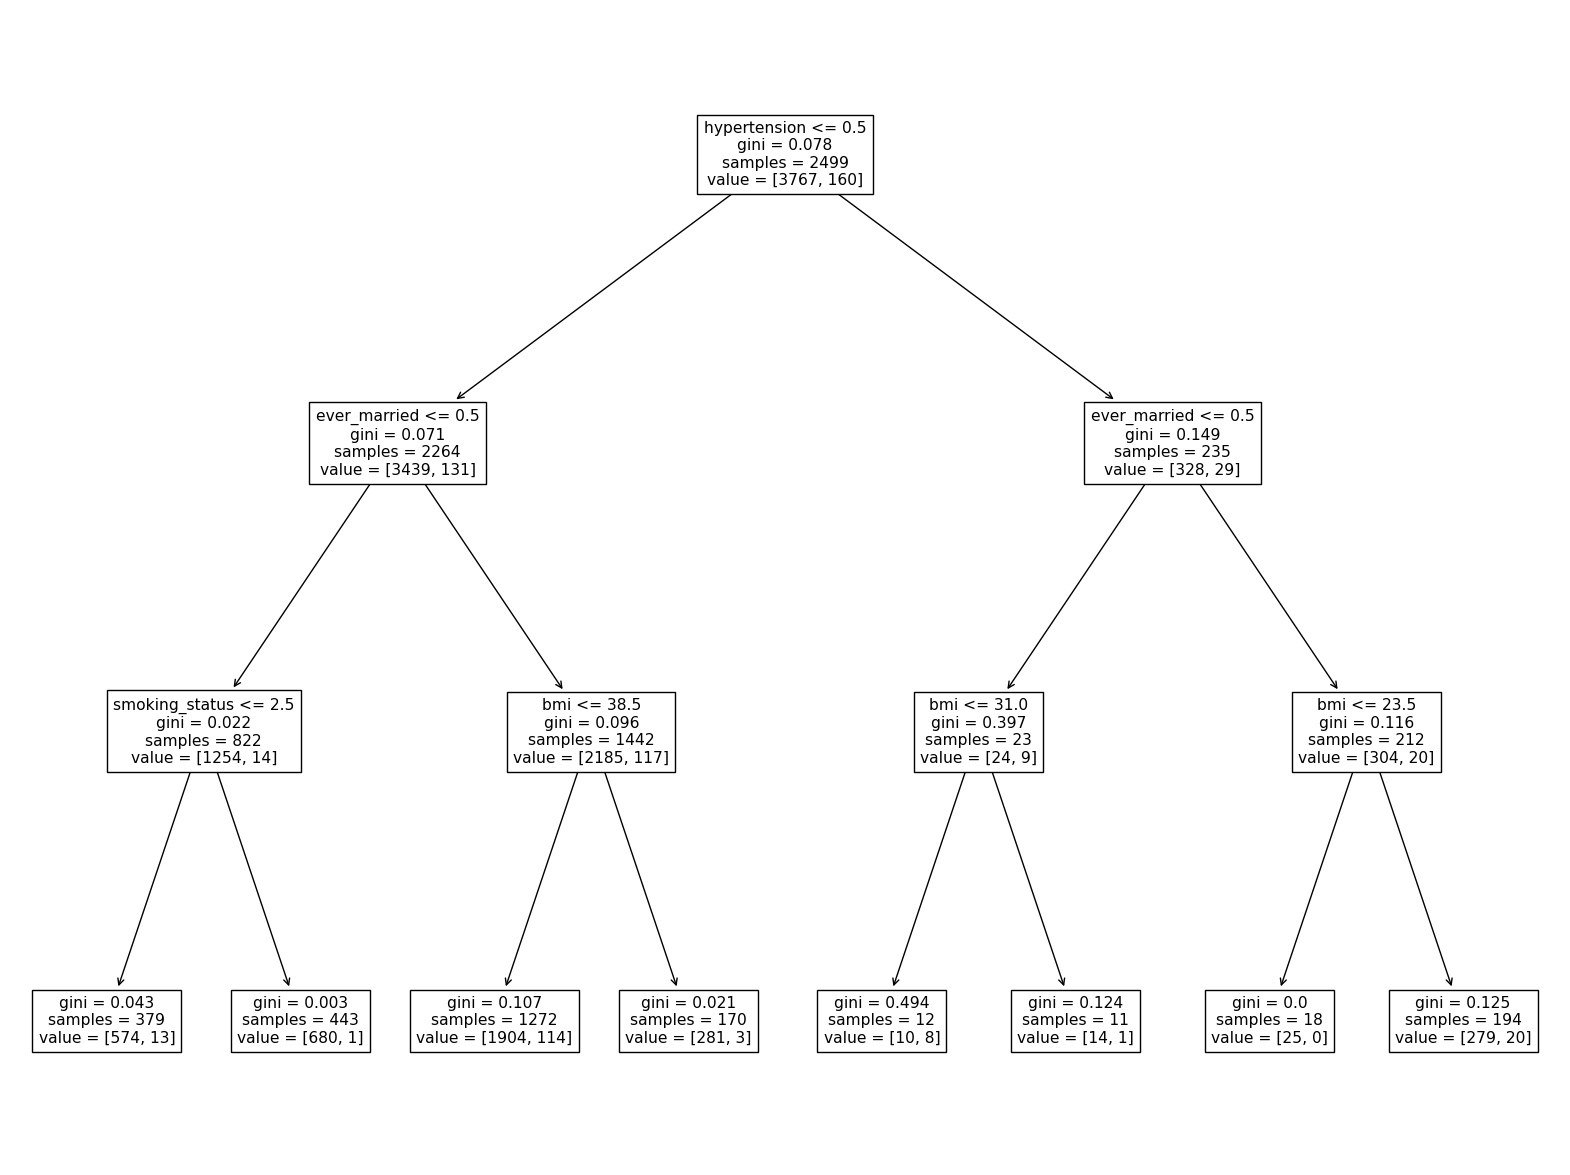

In [15]:
fig = plt.figure(figsize = (20,15))
plot_tree(forest.estimators_[1],
         feature_names = x.columns)

In [16]:
features = forest.feature_importances_

In [17]:
cols = ['hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'bmi',
 'smoking_status']

In [18]:
feature_weight = pd.DataFrame(features, cols)
feature_weight.rename(columns={0: "Weight"}).sort_values(by = "Weight", ascending=False)

,Weight
hypertension,0.305272
heart_disease,0.210941
ever_married,0.190686
bmi,0.171457
work_type,0.091869
smoking_status,0.022639
Residence_type,0.007135


### Our tree is classifying very good even without the obvious columns like age and glucose levels. How ever it is not supported by the shapley package. Now lets try with a NN

In [19]:
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9)

In [20]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(7,)))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='BinaryCrossentropy',
optimizer='sgd',
metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 16)                128       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                544       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 8)                

In [31]:
model.fit(X_train, y_train,epochs=100, batch_size = 64)

Epoch 1/100
 1/62 [..............................] - ETA: 20s - loss: 0.8606 - accuracy: 0.0938

2023-01-16 16:38:36.636841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - 1s 7ms/step - loss: 0.7164 - accuracy: 0.5067
Epoch 2/100
62/62 [==============================] - 0s 6ms/step - loss: 0.5551 - accuracy: 0.9386
Epoch 3/100
62/62 [==============================] - 0s 5ms/step - loss: 0.4665 - accuracy: 0.9559
Epoch 4/100
62/62 [==============================] - 0s 5ms/step - loss: 0.4052 - accuracy: 0.9590
Epoch 5/100
62/62 [==============================] - 0s 6ms/step - loss: 0.3594 - accuracy: 0.9590
Epoch 6/100
62/62 [==============================] - 0s 5ms/step - loss: 0.3231 - accuracy: 0.9593
Epoch 7/100
62/62 [==============================] - 0s 6ms/step - loss: 0.2950 - accuracy: 0.9593
Epoch 8/100
62/62 [==============================] - 0s 6ms/step - loss: 0.2716 - accuracy: 0.9593
Epoch 9/100
62/62 [==============================] - 0s 5ms/step - loss: 0.2540 - accuracy: 0.9593
Epoch 10/100
62/62 [==============================] - 0s 5ms/step - loss: 0.2358 - accuracy: 0.9593
Epoch 11/100
62/62 [=

62/62 [==============================] - 0s 5ms/step - loss: 0.1648 - accuracy: 0.9593
Epoch 84/100
62/62 [==============================] - 0s 5ms/step - loss: 0.1662 - accuracy: 0.9593
Epoch 85/100
62/62 [==============================] - 0s 5ms/step - loss: 0.1631 - accuracy: 0.9593
Epoch 86/100
62/62 [==============================] - 0s 5ms/step - loss: 0.1616 - accuracy: 0.9593
Epoch 87/100
62/62 [==============================] - 0s 5ms/step - loss: 0.1666 - accuracy: 0.9593
Epoch 88/100
62/62 [==============================] - 0s 6ms/step - loss: 0.1644 - accuracy: 0.9593
Epoch 89/100
62/62 [==============================] - 0s 5ms/step - loss: 0.1631 - accuracy: 0.9593
Epoch 90/100
62/62 [==============================] - 0s 5ms/step - loss: 0.1651 - accuracy: 0.9593
Epoch 91/100
62/62 [==============================] - 0s 5ms/step - loss: 0.1645 - accuracy: 0.9593
Epoch 92/100
62/62 [==============================] - 0s 5ms/step - loss: 0.1639 - accuracy: 0.9593
Epoch 93/100


In [32]:
explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

2023-01-16 16:39:22.305946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


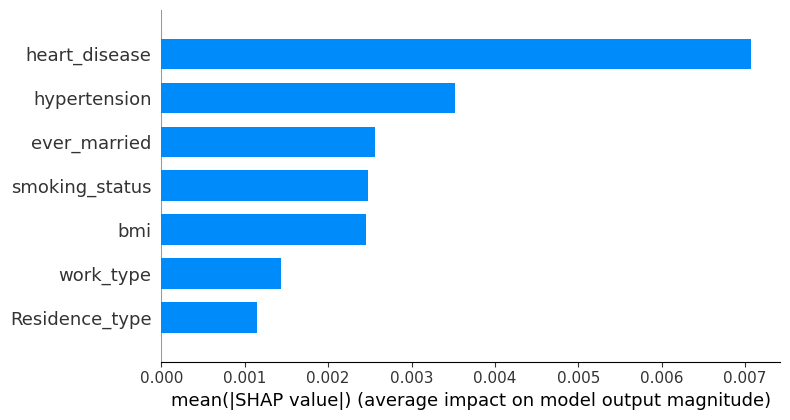

In [33]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = x.columns)

#### Local Interpretation methods
##### Force plot
The force plot is great for seeing where the “output value” fits in relation to the “base value”. 
Further, it is possible to observe which features have a positive (red) or negative (blue) impact on the prediction and in addition the magnitude of the impact.

In [34]:
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = x.columns)

##### Decision plot
The decision plot enables to observe the amplitude of each change taken by a sample for the values of the displayed features.

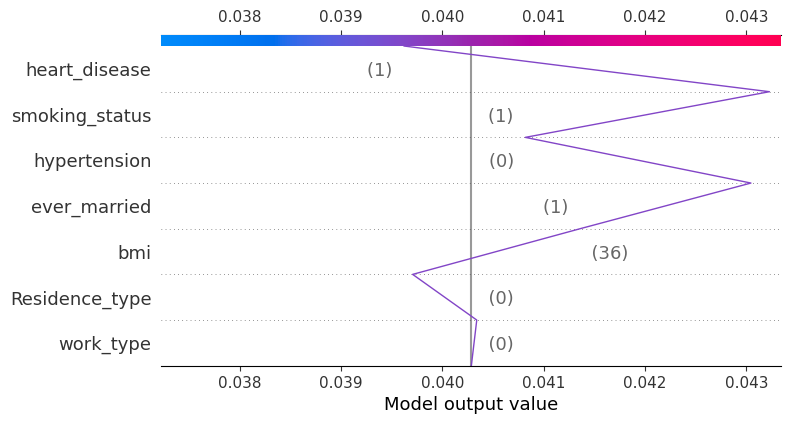

In [35]:
shap.decision_plot(explainer.expected_value[0].numpy(), shap_values[0][0], features = x.iloc[0,:], 
                   feature_names = x.columns.tolist())

##### Waterfall plot
The waterfall plot allows for seeing the amplitude and the nature of the impact of a feature. 
It also allows for seeing the order of importance of the features and the values taken by each feature for the sample.

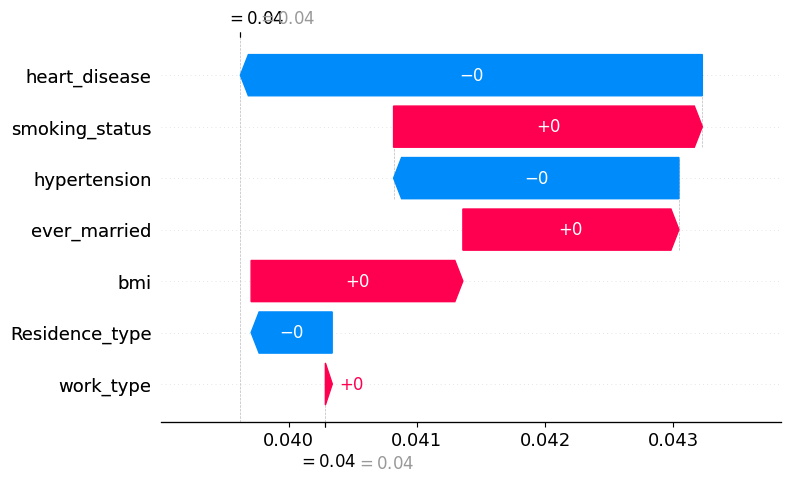

In [36]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][0], 
                                       feature_names = x.columns)

### Summary

The dataset is not perfect for using a NN and the Shapley values on it. Maybe this data has problems with the scaling, however the shapley values are pretty much unuseable.